<img src="https://drive.google.com/uc?export=view&id=1HeAacvOTc_6kyTCdkGO5ENzNtSCKcmvO" width="1000" height="350">



#🔍Search Engine


###📌This project was done for the Multi-media, Information Retrival and Computer vision (MIRCV) course at UNIPI for AIDE master's degree

by:

- **Nedal Adham**

- **Basma Adawy**

- **Francesco De Vita**


This project implements an information retrieval system for the MS MARCO passage collection using the BM25 ranking algorithm.

About the dataset:

MS MARCO (MicroSoft MAchine Reading COmprehension) is a large-scale dataset focused on machine reading comprehension. Since its initial release, benchmarking efforts for several NLP and IR tasks have made use of this dataset—incl. question-answering, passage ranking, document ranking, keyphrase extraction, and conversational search.

source https://microsoft.github.io/msmarco/Datasets.html

###Installation

PyTerrier & Python-Terrier

Python frameworks for information retrieval (IR) research. It provides tools for building search engines, running experiments, and evaluating retrieval systems.

What PyTerrier does:

- Provides a Python interface for Terrier (a popular Java-based IR platform)

- Allows you to index and search document collections

- Includes retrieval models, query expansion methods, and evaluation tools

- Supports learning-to-rank and neural ranking models

In [1]:
  pip install pyterrier python-terrier

What is pt.datasets?
PyTerrier's datasets module provides pre-loaded IR datasets (e.g., TREC collections, MS MARCO) for experimentation.

These datasets are often used for benchmarking search and retrieval models.

In [2]:
import pyterrier as pt
pt.datasets.__dict__                 #list all the attributes and methods available in the datasets module of the PyTerrier library
                                     # returns a dictionary of all accessible names (functions, classes, variables) in the datasets module.


{'__name__': 'pyterrier.datasets',
 '__doc__': None,
 '__package__': 'pyterrier',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x7f976e5886d0>,
 '__spec__': ModuleSpec(name='pyterrier.datasets', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f976e5886d0>, origin='/usr/local/lib/python3.11/dist-packages/pyterrier/datasets.py'),
 '__file__': '/usr/local/lib/python3.11/dist-packages/pyterrier/datasets.py',
 '__cached__': '/usr/local/lib/python3.11/dist-packages/pyterrier/__pycache__/datasets.cpython-311.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, types, exceptions, and other objects.\n\nThis module provides direct access to all 'built-in'\nidentifiers of Python; for example, builtins.len is\nthe full name for the built-in function len().\n\nThis module is not normally accessed explicitly by most\napplications, but can be useful in modules that provide\nobjects with the same name as a built-in value, but in\nwhich th

In [3]:
# necessary imports
import gdown
from tqdm.auto import tqdm
from tqdm import tqdm
import re
import pickle
import time
import pyterrier as pt
import numpy as np
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import nltk, os, pickle, time, re, string, gdown, humanize


In [4]:
# Init PyTerrier (starts Java VM)
pt.init()

Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
<ipython-input-4-8c4ce45697e5>:2: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


##Preprocessing

In [5]:
# Download NLTK stopwords
nltk.download("stopwords", quiet=True)
stopwords = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer().stem

# Regex and translation table for text cleaning
acronym_re = re.compile(r"\.(?!(\S))")  # Remove standalone dots
punctuation_wo_dot = string.punctuation.replace(".", "")
trans_table = str.maketrans("‘’´“”–-" + punctuation_wo_dot, "'''\"\"--" + " " * len(punctuation_wo_dot))

def preprocess(text):
    """Normalize, tokenize, remove stopwords, and stem text."""
    text = text.lower().replace("&", " and ")
    text = acronym_re.sub("", text).translate(trans_table).split()  # Clean punctuation
    text = filter(lambda t: t not in stopwords, text)  # Remove stopwords
    return list(map(stemmer, text))  # Apply Porter stemmer

##Load Dataset



In [6]:
# Constants
DOCS = 8841823  # (8.84 million) Total documents in MS MARCO

# Load MS MARCO passage dataset
dataset = pt.get_dataset("msmarco_passage")
queries = dataset.get_topics("test-2020")  # Test queries
qrels = dataset.get_qrels("test-2020")     # Relevance judgments
print(f"Loaded {len(queries)} queries and {len(qrels)} relevance judgments.")
dataset.get_corpus()

Loaded 200 queries and 11386 relevance judgments.


['/root/.pyterrier/corpora/msmarco_passage/corpus/collection.tsv']

In [7]:
#Sample Queries
print(queries.head(3))

       qid                             query
0  1030303                who is aziz hashim
1  1037496                who is rep scalise
2  1043135  who killed nicholas ii of russia


In [8]:
#Sample Qrels (relevance judgments):
print(qrels.head(3))

     qid    docno  label
0  23849  1020327      2
1  23849  1034183      3
2  23849  1120730      0


In [9]:
# Download pre-built index as it takes almost 2 hours to be built
file_id = "1CLP9fdGy6y0jZcewzMdRnikbs4UjIReX"
file_name = "index.pickle"
gdown.download(
    f"https://drive.google.com/uc?id={file_id}",
    file_name, quiet=False  # Show progress bar
)
print("Index downloaded.")

Downloading...
From (original): https://drive.google.com/uc?id=1CLP9fdGy6y0jZcewzMdRnikbs4UjIReX
From (redirected): https://drive.google.com/uc?id=1CLP9fdGy6y0jZcewzMdRnikbs4UjIReX&confirm=t&uuid=04b8453c-ed94-4270-929d-d4ba11f24c94
To: /content/index.pickle
100%|██████████| 1.93G/1.93G [00:39<00:00, 49.1MB/s]


Index downloaded.


##Indexing

Constructs an inverted index from a document collection for efficient retrieval.

**Data Structures:**

Lexicon: {term: [document_frequency, collection_frequency]}

Postings: {term: [doc_ids]}

Term Frequencies: {term: [frequencies]}

Document Index: {doc_id: (length, normalization_factor)}

Collection Statistics: Stores num_docs, num_terms, avg_doc_len

**Index Construction Process:**

Iterates through all documents in the collection

Processes each document's text through the preprocessing pipeline

Builds inverted index with document frequencies and term frequencies

Computes document length normalization factors for BM25

In [10]:
def defaultlexicon():
    return [0, 0]              #returns default values for lexicon entries:(df) ,(cf)

def build_index(docs):
    """Build inverted index from document collection

    Args:
        docs: Iterable of documents from PyTerrier

    Returns:
        Dictionary containing:
        - lexicon: Term statistics (df, cf)
        - docids: Posting lists (document IDs for each term)
        - freqs: Term frequencies in documents
        - doc_index: Document lengths and normalization factors
        - stats: Collection statistics
    """
    # Lexicon: term -> [document frequency, collection frequency]
    lexicon = defaultdict(defaultlexicon)

    # Posting lists: term -> list of document IDs
    docids = defaultdict(list)

    # Term frequencies: term -> list of frequencies in documents
    freqs = defaultdict(list)

    # Document index: docid -> (length, normalization factor)
    doc_index = {}

    # Sum of all document lengths (for computing average)
    doc_len_sum = 0

    # Process each document with progress bar
    for doc in tqdm(docs.get_corpus_iter(), total=DOCS):
        docid = doc["docno"]                    # Get document ID
        tokens = preprocess(doc["text"])        # Preprocess document text into tokens
        token_tf = Counter(tokens)              # Count term frequencies in this document
        doc_index[docid] = (len(tokens), 0)     # Store document length (initial normalization factor is 0)
        doc_len_sum += len(tokens)              # Add to total length sum

        # Update index for each unique term in document
        for token, tf in token_tf.items():
            # Increment document frequency
            lexicon[token][0] += 1
            # Add to collection frequency
            lexicon[token][1] += tf
            # Add document ID to term's posting list
            docids[token].append(docid)
            # Add term frequency to parallel list
            freqs[token].append(tf)

    # Collection statistics
    stats = {
        "num_docs": int(docid),  # Total documents processed
        "num_terms": len(lexicon),  # Unique terms
        "avg_doc_len": doc_len_sum / DOCS,  # Average document length
    }

    return {
        "lexicon": lexicon,
        "docids": docids,
        "freqs": freqs,
        "doc_index": doc_index,
        "stats": stats,
    }


In [11]:
# Load or build index
# Check if index file exists
if not os.path.exists("index.pickle"):
    print("Building index from scratch...")
    # Build index from dataset
    index = build_index(dataset)

    # BM25 length normalization parameter
    b = 0.75

    # Compute normalization factors for all documents
    for docid, (doc_len, _) in tqdm(index["doc_index"].items(), total=DOCS):
        # BM25 normalization: (1 - b) + b * (doc_len / avg_doc_len)
        index["doc_index"][docid] = (
            doc_len,
            (1 - b) + b * (doc_len / index["stats"]["avg_doc_len"])
        )

    # Save index to file
    with open("index.pickle", "wb") as f:
        pickle.dump(index, f)
else:
    # Load existing index
    with open("index.pickle", "rb") as f:
        index = pickle.load(f)
    print(f"Loaded index with {index['stats']['num_docs']} documents")

Loaded index with 8841822 documents


##Retrieval

**BM25 Implementation**

Query Processing:

Applies same preprocessing as documents

Scores documents containing any query term

Returns ranked list of documents by descending BM25 score

In [12]:
def bm25_ranking(query, index: dict, k=1.5, b=0.75):
    """Rank documents using BM25 algorithm

    Args:
        query: Search query string
        index: Prebuilt index dictionary
        k: BM25 term frequency saturation parameter
        b: BM25 document length normalization parameter

    Returns:
        List of (doc_id, score) tuples sorted by score descending
    """

    query_tokens = preprocess(query)    # Preprocess query into tokens
    scores = defaultdict(float)         # Dictionary to accumulate scores for each document

    # Process each query term
    for token in query_tokens:
        if token not in index["lexicon"]:
            continue                    # Skip terms not in vocabulary

        doc_freq = len(index["docids"][token])      # Get document frequency for term

        # Process each document containing the term
        for doc_id, tf in zip(index["docids"][token], index["freqs"][token]):
            idf = np.log(index["stats"]["num_docs"] / doc_freq)         # Inverse document frequency (smooth log)
            norm_tf = tf / (tf + k * index["doc_index"][doc_id][1])     # Normalized term frequency (BM25 variant)
            scores[doc_id] += idf * norm_tf                             # Add to document's score

    # Return documents sorted by score (highest first)
    return sorted(scores.items(), key=lambda item: item[1], reverse=True)


##Evaluation Metrics

Metrics Implemented:

**nDCG@10: Normalized Discounted Cumulative Gain at rank 10**

Measures ranking quality with graded relevance

**AP@10: Average Precision at rank 10Z**

Measures precision-recall tradeoff, Suitable for binary relevance judgments

In [13]:
def ndcg_at_k(r, k):
    """Calculate normalized discounted cumulative gain at rank k

    Args:
        r: List of relevance scores
        k: Cutoff rank

    Returns:
        nDCG@k score (0.0 to 1.0)
    """
    def dcg_at_k(r, k):
        """Calculate discounted cumulative gain"""
        r = np.asarray(r)[:k]  # Get top k results
        return sum(
            r[i] / max(1, np.log2(i + 1))  # Discount by log position
            for i in range(0, len(r))
        )

    # Ideal DCG (sorted in perfect order)
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    # Normalize actual DCG by ideal DCG
    return dcg_at_k(r, k) / idcg if idcg else 0.0


In [14]:
def average_precision_at_k(r, k):
    """Calculate average precision at rank k

    Args:
        r: List of binary relevance judgments (0 or 1)
        k: Cutoff rank

    Returns:
        Average precision score
    """
    # Convert to binary array and get top k
    r = np.asarray(r)[:k] != 0

    # Number of relevant documents
    N = sum(r)

    # Compute average precision
    return (
        sum([
            sum(r[: i + 1]) / (i + 1) * r[i]  # Precision at i * rel(i)
            for i in range(k)
        ]) / N  # Normalize by total relevant
    ) if N else 0  # Handle case with no relevant docs

##Visualization:

Generates plots of metric values across all queries

Shows performance consistency and outliers

In [15]:
def evaluation(timing=True, evaluate=True):
    """Run it on all test queries

    Args:
        timing: Whether to measure query processing time
        evaluate: Whether to compute evaluation metrics
    """
    # Lists to store metrics per query
    ndcg_at_10 = []
    average_precisions_at_10 = []

    # Average ranking time tracking
    average_ranking_time = 0

    # Process each query with progress bar
    for i, query in tqdm(queries.iterrows(), total=len(queries)):
        # Start timer if timing
        start = time.perf_counter()

        # Run BM25 ranking
        results = bm25_ranking(query["query"], index)

        # Update timing statistics
        if timing:
            end = time.perf_counter()
            average_ranking_time = (i * average_ranking_time + end - start) / (i + 1)

        # Compute evaluation metrics if enabled
        if evaluate:
            # Get relevance judgments for this query
            rel_qrels = qrels[qrels["qid"] == query["qid"]].set_index("docno")

            # Create list of relevance scores for returned documents
            relevance_judgments = [
                rel_qrels["label"].get(docno, 0)  # 0 if not in qrels
                for docno, _ in results
            ]

            # Compute metrics
            ndcg = ndcg_at_k(relevance_judgments, 10)
            ap = average_precision_at_k(relevance_judgments, 10)

            # Store metrics
            ndcg_at_10.append(ndcg)
            average_precisions_at_10.append(ap)

    # Print results if evaluation was enabled
    if evaluate:
        print("----------------------------------------------------------")
        print(f"Mean nDCG@10:\t\t{np.mean(ndcg_at_10):.5f}")
        print(f"Mean AP@10:\t\t{np.mean(average_precisions_at_10):.5f}")

        # Plot metrics
        plot_metrics(ndcg_at_10, average_precisions_at_10)

def plot_metrics(ndcg, ap):
    """Plot evaluation metrics over all queries

    Args:
        ndcg: List of nDCG@10 scores
        ap: List of AP@10 scores
    """
    # Create figure with 2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Plot nDCG scores
    axs[0].plot(ndcg, color='blue', label="nDCG@10")
    axs[0].set_title("nDCG@10 per Query")
    axs[0].set_xlabel("Query Index")
    axs[0].set_ylabel("nDCG@10")

    # Plot AP scores
    axs[1].plot(ap, color='green', label="AP@10")
    axs[1].set_title("AP@10 per Query")
    axs[1].set_xlabel("Query Index")
    axs[1].set_ylabel("AP@10")

    # Configure both subplots
    for ax in axs:
        ax.grid(True)  # Show grid
        ax.legend()  # Show legend

    # Adjust layout
    plt.tight_layout()

    # Display plot
    plt.show()


100%|██████████| 200/200 [18:01<00:00,  5.41s/it]


----------------------------------------------------------
Mean nDCG@10:		0.13329
Mean AP@10:		0.20396


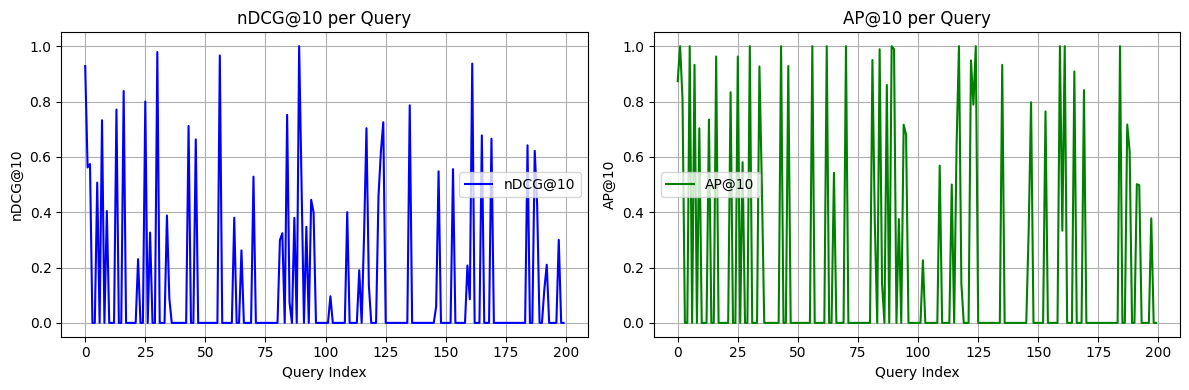

In [16]:
evaluation(timing=True, evaluate=True)       #run the complete evaluation